In [1]:
from Bio import Nexus, Phylo, SeqIO
from collections import defaultdict
from io import StringIO

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import re
from pathlib import Path

from itertools import combinations
from evaluation_helpers import *

# Evaluate estimation of population size with skyline / constant coalescent prior in BEAST

In [3]:
input_csv = "../scripts/successful_mcmc_runs.csv" 
df = process_results(input_csv)
df.head()

,population_model,mutation_signal,tree_index,sim_tree_path,present_pop_size,growth_rate,log_path_constcoal,log_path_skyline,tree_path_constcoal,tree_path_skyline
0,expgrowth_fast,high,0,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
1,expgrowth_fast,high,1,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
2,expgrowth_fast,high,2,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
3,expgrowth_fast,high,3,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
4,expgrowth_fast,high,4,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...


In [8]:
df.sim_tree_path[0]

'/Users/mariebecker/Documents/Uni/ETH/RotationStadler/BESP_paper-analyses/results/pop_size_simulations/independent_homochronous/expgrowth_fast/expgrowth_fast.trees'

In [5]:
log_test_path = "/Users/mariebecker/Documents/Uni/ETH/RotationStadler/BESP_paper-analyses/scripts/../results/pop_size_simulations/simulation_results/homochronous_independent/skyline/expgrowth_fast/highmutsig/skyline_homochronous_expgrowth_fast_highmutsig.T0.log"
log_test_path_coal = "/Users/mariebecker/Documents/Uni/ETH/RotationStadler/BESP_paper-analyses/scripts/../results/pop_size_simulations/simulation_results/homochronous_independent/constcoal/expgrowth_fast/highmutsig/constcoal_homochronous_expgrowth_fast_highmutsig.T0.log"
get_mean_population_size(log_test_path, burnin=0.1, mode="skyline")

array([1952.05841146, 1145.5039451 , 1705.81842665, 2786.01905859,
       1011.25345533, 1490.28527636, 2191.63160118, 1435.94395048,
       1620.2638372 , 1028.21221727])

In [6]:
tree_test_path = "/Users/mariebecker/Documents/Uni/ETH/RotationStadler/BESP_paper-analyses/scripts/../results/pop_size_simulations/simulation_results/homochronous_independent/skyline/expgrowth_fast/highmutsig/skyline_homochronous_expgrowth_fast_highmutsig.T0.tree"
tree_test = Phylo.read(tree_test_path, "nexus")

In [7]:
get_skyline_group_boundaries(tree_test, num_groups=10)

[1.8102883119565831,
 2.855463196460164,
 5.294540588061523,
 11.227596098083382,
 13.739510868289472,
 20.125125082176964,
 34.59924771586088,
 55.55807245868573,
 120.44345570250141,
 763.787827354847]

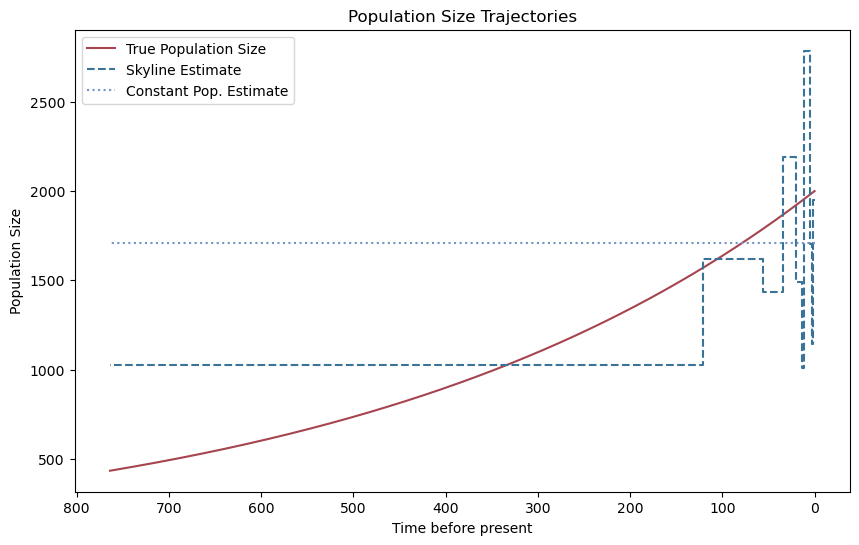

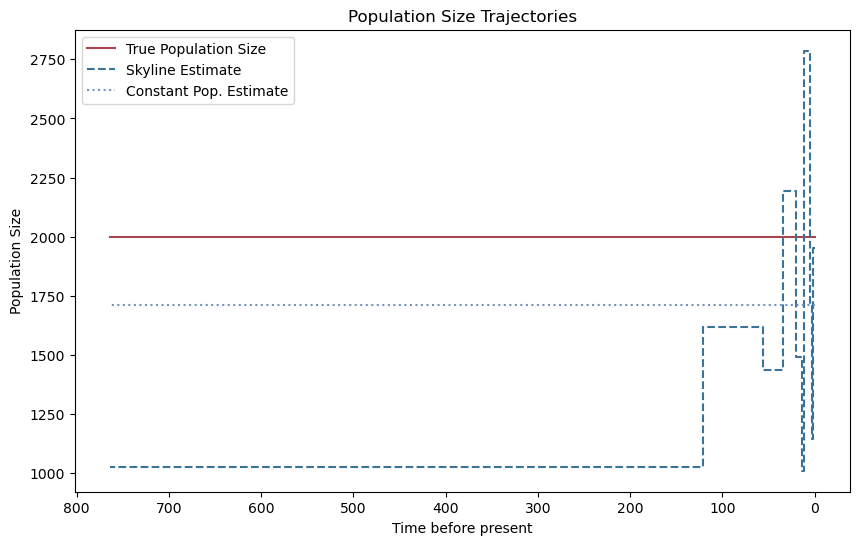

In [9]:
def plot_population_trajectories(skyline_times, skyline_means, constant_pop_estimate, present_pop_size, growth_rate = None):
    """
    Plots:
    - Exponential population growth (true)
    - Stepwise skyline population size estimates
    - Constant population estimate (overall mean)
    
    Parameters:
        skyline_times (list): End time points of skyline intervals (backward in time, ascending).
        skyline_means (list): Mean population sizes for each interval.
        present_pop_size (float): True present-day population size (N0).
        growth_rate (float): Exponential growth rate (r).
        constant_pop_estimate (float): Overall mean population size.
    """
    root_height = skyline_times[-1]  # The last time point is the root height (earliest time)

    # True exponential function (from root to present, i.e., from T to 0)
    t_vals = np.linspace(0, root_height, 1000)
    N_true = present_pop_size * np.exp(-growth_rate * t_vals)

    # Stepwise skyline values
    skyline_start_times = [0.0] + skyline_times[:-1]
    skyline_end_times = skyline_times
    step_times = []
    step_values = []

    for start, end, value in zip(skyline_start_times, skyline_end_times, skyline_means):
        step_times.extend([start, end])
        step_values.extend([value, value])

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(t_vals, N_true, label="True Population Size", color = '#a6444f')
    plt.plot(step_times, step_values, drawstyle='steps-post', label="Skyline Estimate", linestyle = "--", color = "#397398")
    plt.hlines(constant_pop_estimate, 0, root_height, color='#7394c2', linestyle=':', label="Constant Pop. Estimate")

    plt.xlabel("Time before present")
    plt.ylabel("Population Size")
    plt.title("Population Size Trajectories")
    plt.legend()
    plt.gca().invert_xaxis()  # show present (0) on the right
    plt.show()


skyline_times = get_skyline_group_boundaries(tree_test, num_groups=10)
skyline_means = get_mean_population_size(log_test_path, burnin=0.1, mode="skyline")
coalescent_mean = get_mean_population_size(log_test_path_coal, burnin=0.1, mode="constcoal")

plot_population_trajectories(skyline_times, skyline_means, 
                             present_pop_size=2000, growth_rate=0.002, 
                             constant_pop_estimate=coalescent_mean)

plot_population_trajectories(skyline_times, skyline_means, 
                             present_pop_size=2000, growth_rate=0, 
                             constant_pop_estimate=coalescent_mean)


In [ ]:
def plot_population_trajectories_ax(ax, skyline_times, skyline_means, constant_pop_estimate, 
                                     present_pop_size, growth_rate=None,
                                     color_exp="#a6444f", color_sky="#397398", color_const="#7394c2",
                                     alpha=0.4, label_prefix=""):
    """
    Plots population trajectories into a given axis:
    - True exponential (or constant) growth
    - Skyline step function
    - Constant estimate

    Parameters:
        ax (matplotlib.axes.Axes): Axis to draw on.
        skyline_times (list): Endpoints of skyline intervals (ascending).
        skyline_means (list): Mean pop sizes per interval.
        constant_pop_estimate (float): Overall mean pop size.
        present_pop_size (float): N0
        growth_rate (float or None): Exponential rate (if None: flat line)
        label_prefix (str): To make labels unique in legend.
    """
    root_height = skyline_times[-1]
    t_vals = np.linspace(0, root_height, 1000)
    
    # True population
    if growth_rate:
        N_true = present_pop_size * np.exp(-growth_rate * t_vals)
    else:
        N_true = np.repeat(present_pop_size, len(t_vals))
    ax.plot(t_vals, N_true, color=color_exp, alpha=alpha, label=f"{label_prefix}True Population Size")

    # Skyline
    if skyline_means != None:
        skyline_start_times = [0.0] + skyline_times[:-1]
        step_times, step_values = [], []
        for start, end, val in zip(skyline_start_times, skyline_times, skyline_means):
            step_times.extend([start, end])
            step_values.extend([val, val])
        ax.plot(step_times, step_values, drawstyle='steps-post', linestyle='--', color=color_sky, 
                alpha=alpha, label=f"{label_prefix}Skyline Estimate")

    # Constant estimate
    if constant_pop_estimate != None:
        ax.hlines(constant_pop_estimate, 0, root_height, color=color_const, linestyle=':', 
              alpha=alpha, label=f"{label_prefix}Constant Estimate")

    ax.invert_xaxis()


def plot_summary_population_grid(path_info_df, num_groups=10, burnin=0.1):
    """
    Plots all population trajectories for all trees in a subplot grid by
    population model (columns) and mutation signal (rows).
    
    Parameters:
        path_info_df (pd.DataFrame): Table with tree/log paths and metadata.
        present_pop_size (float): N0
        growth_rate (float): Exponential growth rate
        num_groups (int): Number of skyline intervals
        burnin (float or int): Burnin for BEAST logs
    """
    pop_models = sorted(path_info_df["population_model"].dropna().unique())
    mut_signals = sorted(path_info_df["mutation_signal"].dropna().unique())
    ncols, nrows = len(pop_models), len(mut_signals)

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.5*nrows), sharex=True, sharey=True)

    # Ensure axes is always 2D array
    if nrows == 1:
        axes = np.expand_dims(axes, axis=0)
    if ncols == 1:
        axes = np.expand_dims(axes, axis=1)

    for idx, row in path_info_df.iterrows():
        
        tree_path_constcoal = row["tree_path_constcoal"]
        tree_path_skyline = row["tree_path_skyline"]
        log_path_constcoal = row["log_path_constcoal"]
        log_path_skyline = row["log_path_skyline"]
        pop_model = row["population_model"]
        mut_sig = row["mutation_signal"]
        present_pop_size = row["present_pop_size"]
        growth_rate = row["growth_rate"]

        row_idx = mut_signals.index(mut_sig)
        col_idx = pop_models.index(pop_model)
        ax = axes[row_idx][col_idx]

        # Parse data
        if tree_path_skyline != None:
            tree = Phylo.read(tree_path_skyline, "nexus")
            skyline_times = get_skyline_group_boundaries(tree, num_groups=num_groups)
        else: 
            skyline_times = None
        skyline_means = get_mean_population_size(log_path_skyline, burnin=burnin, mode="skyline")
        coalescent_mean = get_mean_population_size(log_path_constcoal, burnin=burnin, mode="constcoal")

        # Plot into axis
        plot_population_trajectories_ax(
            ax,
            skyline_times=skyline_times,
            skyline_means=skyline_means,
            constant_pop_estimate=coalescent_mean,
            present_pop_size=present_pop_size,
            growth_rate=growth_rate,
            alpha=0.3  # overlay transparency
        )

    # Axis labeling
    for i, mut_sig in enumerate(mut_signals):
        axes[i][0].set_ylabel(f"{mut_sig.capitalize()} mut.\nsignal\nPopulation Size")

    for j, pop_model in enumerate(pop_models):
        axes[-1][j].set_xlabel(f"{pop_model}")

    # Add global legend
    handles, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=3)
    fig.suptitle("Population Size Trajectories across Trees", y=1.07)
    plt.tight_layout(rect=[0, 0, 1, 1.05])
    plt.show()



TypeError: 'float' object is not subscriptable

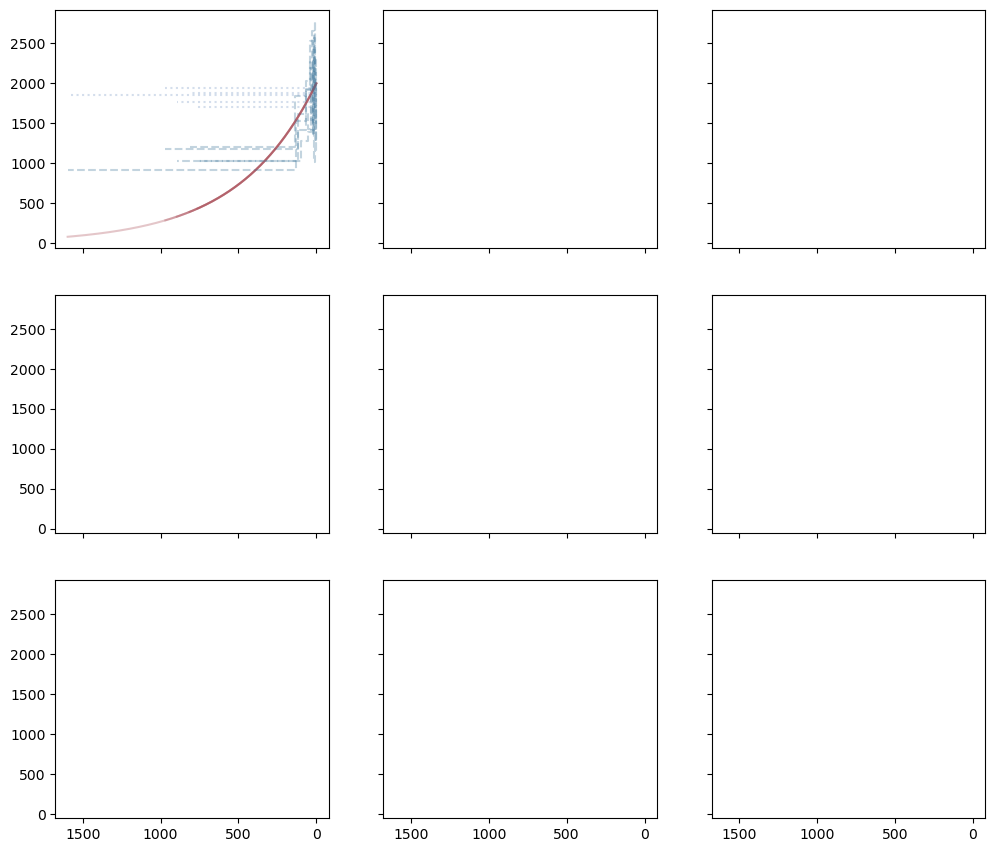

In [11]:
plot_summary_population_grid(df)